# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [1]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
import napari
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [3]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media

# Prepare the dataset
## 1. Get copick root

In [4]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
#tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [5]:
root

CopickRoot(user_id=None, len(pickable_objects)=None, len(runs)=None) at 0x7bcb369f8530

In [6]:
# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            image = tomogram.numpy()
            target = np.zeros(image.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id='curation')
                if len(pick):
                    target = segmentation_from_picks.from_picks(pick[0],
                                                                target,
                                                                target_objects[pickable_object.name]['radius'],
                                                                target_objects[pickable_object.name]['label']
                                                               )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|█████████████████████████████████████████████| 7/7 [00:15<00:00,  2.21s/it]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [7]:
data_dicts = []
for run in tqdm(root.runs):
    tomo = run.get_voxel_spacing(voxel_size)#.get_tomograms(tomo_type)[0].numpy()
    for tomogram in tomo.tomograms:
        tomo_type = tomogram.tomo_type
        image = tomogram.numpy()
        segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
        data_dicts.append({"tomo_type":tomo_type, "image": image, "label": segmentation})
    
print(np.unique(data_dicts[0]['label']))

100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.61s/it]


[0 1 3 4 5 6]


In [8]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label'])

In [9]:
data_dicts[0]['label'].shape

(184, 630, 630)

In [10]:
len(data_dicts)

28

## 4. Visualize the tomogram and painted segmentation from ground-truth picks

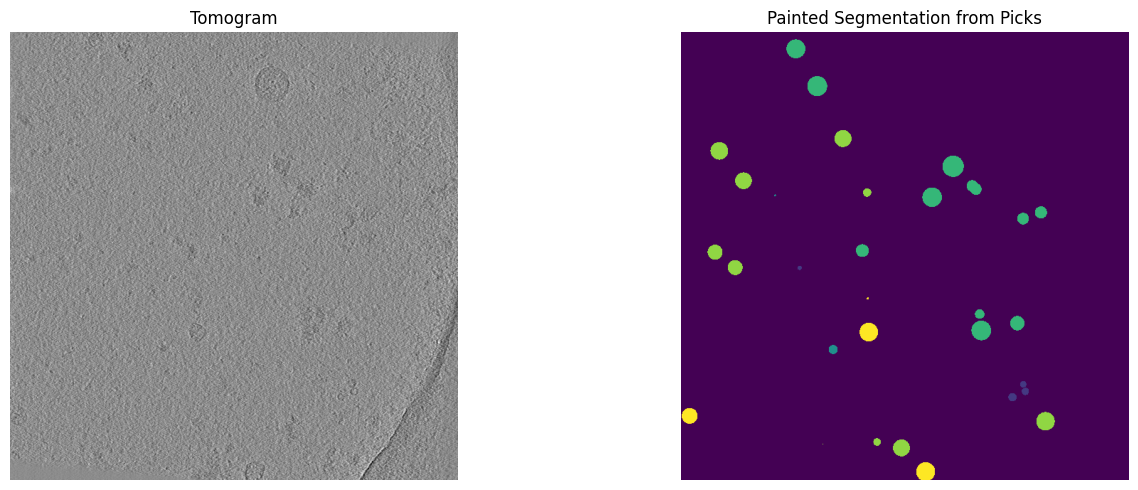

In [11]:
# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

# Simulated data prep

In [12]:
simulated_data_path = '../../czii_downloaded_data/simulated_training_data/'

In [13]:
simulated_experiments_list = [f for f in os.listdir(simulated_data_path) if 'TS_' in f]
simulated_experiments_list

['TS_26',
 'TS_13',
 'TS_22',
 'TS_17',
 'TS_1',
 'TS_24',
 'TS_19',
 'TS_4',
 'TS_6',
 'TS_23',
 'TS_2',
 'TS_16',
 'TS_14',
 'TS_20',
 'TS_18',
 'TS_0',
 'TS_21',
 'TS_3',
 'TS_9',
 'TS_7',
 'TS_10',
 'TS_11',
 'TS_25',
 'TS_12',
 'TS_15',
 'TS_5',
 'TS_8']

In [14]:
particle_info = {
    "apo-ferritin": {"label": 1, "radius": 60},
    "beta-galactosidase": {"label": 3, "radius": 90},
    "ribosome": {"label": 4, "radius": 150},
    "thyroglobulin": {"label": 5, "radius": 130},
    "virus-like-particle": {"label": 6, "radius": 135}
}

In [15]:
def create_masks(image, locations_df):
    shape = image.shape
    volume = np.zeros(shape)

    for i in range(locations_df.shape[0]):
        center = (locations_df.loc[i, 'z'], locations_df.loc[i, 'y'], locations_df.loc[i, 'x'])
        radius = locations_df.loc[i, 'radius']
        intensity = locations_df.loc[i, 'label']

        z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
        
        mask = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2 <= radius**2

        volume[mask] = intensity

    return volume

In [16]:
def append_simulation_data():
    for experiment in tqdm(simulated_experiments_list):
        
        tomogram = zarr.open(simulated_data_path + f'{experiment}/Reconstructions/VoxelSpacing10.000/Tomograms/100/{experiment}.zarr', mode='r')[0].__array__()
    
        location_dfs_list = []
        location_folders_list = os.listdir(f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/')
        for location_folder in location_folders_list:
            location_files_list = os.listdir(f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/{location_folder}/')
            for location_file in location_files_list:
                if 'orientedpoint.ndjson' in location_file:
                    if 'ferritin' in location_file:
                        label = particle_info['apo-ferritin']['label']
                        radius = particle_info['apo-ferritin']['radius']
    
                        location_df = pd.read_json(f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/{location_folder}/{location_file}', lines=True)
                        location_df['x'] = location_df['location'].apply(lambda x: x['x'])
                        location_df['y'] = location_df['location'].apply(lambda x: x['y'])
                        location_df['z'] = location_df['location'].apply(lambda x: x['z'])
                        location_df['label'] = label
                        location_df['radius'] = radius / 10
    
                        location_dfs_list.append(location_df)
    
                    elif 'galacto' in location_file:
                        label = particle_info['beta-galactosidase']['label']
                        radius = particle_info['beta-galactosidase']['radius']
    
                        location_df = pd.read_json(f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/{location_folder}/{location_file}', lines=True)
                        location_df['x'] = location_df['location'].apply(lambda x: x['x'])
                        location_df['y'] = location_df['location'].apply(lambda x: x['y'])
                        location_df['z'] = location_df['location'].apply(lambda x: x['z'])
                        location_df['label'] = label
                        location_df['radius'] = radius / 10
    
                        location_dfs_list.append(location_df)
    
                    elif 'ribosome' in location_file:
                        label = particle_info['ribosome']['label']
                        radius = particle_info['ribosome']['radius']
    
                        location_df = pd.read_json(f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/{location_folder}/{location_file}', lines=True)
                        location_df['x'] = location_df['location'].apply(lambda x: x['x'])
                        location_df['y'] = location_df['location'].apply(lambda x: x['y'])
                        location_df['z'] = location_df['location'].apply(lambda x: x['z'])
                        location_df['label'] = label
                        location_df['radius'] = radius / 10
    
                        location_dfs_list.append(location_df)
    
                    elif 'thyro' in location_file:
                        label = particle_info['thyroglobulin']['label']
                        radius = particle_info['thyroglobulin']['radius']
    
                        location_df = pd.read_json(f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/{location_folder}/{location_file}', lines=True)
                        location_df['x'] = location_df['location'].apply(lambda x: x['x'])
                        location_df['y'] = location_df['location'].apply(lambda x: x['y'])
                        location_df['z'] = location_df['location'].apply(lambda x: x['z'])
                        location_df['label'] = label
                        location_df['radius'] = radius / 10
    
                        location_dfs_list.append(location_df)
    
                    elif 'vlp' in location_file:
                        label = particle_info['virus-like-particle']['label']
                        radius = particle_info['virus-like-particle']['radius']
    
                        location_df = pd.read_json(f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/{location_folder}/{location_file}', lines=True)
                        location_df['x'] = location_df['location'].apply(lambda x: x['x'])
                        location_df['y'] = location_df['location'].apply(lambda x: x['y'])
                        location_df['z'] = location_df['location'].apply(lambda x: x['z'])
                        location_df['label'] = label
                        location_df['radius'] = radius / 10
    
                        location_dfs_list.append(location_df)
    
                        
        all_particle_locations_df = pd.concat(location_dfs_list, ignore_index=True)
    
        mask_image = create_masks(tomogram, all_particle_locations_df)
    
        data_dicts.append({"tomo_type":'Unknown', "image": tomogram, "label": mask_image})

In [17]:
append_simulation_data()

100%|███████████████████████████████████████████| 27/27 [22:40<00:00, 50.38s/it]


In [18]:
len(data_dicts)

55

In [ ]:
image = data_dicts[-1]['image']

In [ ]:
data_dicts[-1]['image'].shape

In [ ]:
image = data_dicts[-1]['label']

In [ ]:
viewer = napari.Viewer()
viewer.add_image(image, colormap="gray", name="CryoET Image")

In [ ]:
'''
for i in tqdm(range(len(data_dicts))):
    data = data_dicts[i]
    data_image = data['image']
    data_label = data['label']

    data_image = data_image - np.min(data_image)
    data_image = data_image / np.max(data_image)

    # ✅ Apply padding if necessary
    if data_image.shape != (200, 630, 630):
        padded_image = np.full((200, 630, 630), -1, dtype=data_image.dtype)
        padded_label = np.full((200, 630, 630), 0, dtype=data_label.dtype)
        padded_image[:data_image.shape[0], :data_image.shape[1], :data_image.shape[2]] = data_image
        padded_label[:data_label.shape[0], :data_label.shape[1], :data_label.shape[2]] = data_label
        data_image = padded_image.copy()
        data_label = padded_label.copy()

        data_dicts[i]['image'] = data_image
        data_dicts[i]['label'] = data_label
'''

In [ ]:
for i in range(len(data_dicts)):
    del data_dicts[i]['tomo_type']

In [ ]:
type(data_dicts[-1]['image'].__array__())

In [ ]:
for i in range(len(data_dicts)):
    try:
        data_dicts[i]['image'] = data_dicts[i]['image'].__array__()
    except:
        pass

In [ ]:
for i in range(len(data_dicts)):
    print(type(data_dicts[i]['image']))

## 5. Prepare dataloaders

In [19]:
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric

In [20]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

train_files, val_files = data_dicts[1:-1], [data_dicts[0], data_dicts[-1]]
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

Number of training samples: 53
Number of validation samples: 2


In [21]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

Loading dataset: 100%|████████████████████████████| 2/2 [00:00<00:00,  8.75it/s]


## Model setup

In [24]:
"""
Derived from:
https://github.com/cellcanvas/album-catalog/blob/main/solutions/copick/compare-picks/solution.py
"""

import numpy as np
import pandas as pd

from scipy.spatial import KDTree


class ParticipantVisibleError(Exception):
    pass


def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.25, gamma=2):
        """
        Combined Loss for Multi-Class Segmentation:
        - alpha: Weight for SoftFbeta Loss
        - beta: Weight for Tversky Loss
        - gamma: Weight for Focal Loss
        """
        super(CombinedLoss, self).__init__()
        self.alpha = alpha  # SoftFbeta weight
        self.beta = beta    # Tversky weight
        self.gamma = gamma  # Focal loss weight

    def soft_fbeta_loss(self, y_pred, y_true, beta=4, smooth=1e-5):
        """
        Soft-Fbeta Loss for Multi-Class Segmentation.
        """
        tp = torch.sum(y_true * y_pred, dim=(2, 3, 4))  # Sum over spatial dims
        fp = torch.sum(y_pred, dim=(2, 3, 4)) - tp
        fn = torch.sum(y_true, dim=(2, 3, 4)) - tp

        precision = tp / (tp + fp + smooth)
        recall = tp / (tp + fn + smooth)

        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + smooth)
        return 1 - torch.mean(fbeta)

    def tversky_loss(self, y_pred, y_true, alpha=0.5, smooth=1e-5):
        """
        Tversky Loss for Multi-Class Segmentation.
        """
        tp = torch.sum(y_true * y_pred, dim=(2, 3, 4))
        fp = torch.sum(y_pred, dim=(2, 3, 4)) - tp
        fn = torch.sum(y_true, dim=(2, 3, 4)) - tp

        tversky = (tp + smooth) / (tp + alpha * fp + (1 - alpha) * fn + smooth)
        return 1 - torch.mean(tversky)

    def focal_loss(self, y_pred, y_true, gamma=2, smooth=1e-5):
        """
        Focal Loss for Multi-Class Segmentation.
        """
        ce_loss = F.cross_entropy(y_pred, torch.argmax(y_true, dim=1), reduction='none')
        pt = torch.exp(-ce_loss)
        focal = (1 - pt) ** gamma * ce_loss
        return torch.mean(focal)

    def forward(self, y_pred, y_true):
        """
        Compute Total Loss.
        """
        y_pred = torch.softmax(y_pred, dim=1)  # Ensure probability values
        y_true = F.one_hot(y_true.long(), num_classes=y_pred.shape[1]).permute(0, 4, 1, 2, 3).float()  # One-hot encoding

        soft_fbeta = self.soft_fbeta_loss(y_pred, y_true)
        tversky = self.tversky_loss(y_pred, y_true)
        focal = self.focal_loss(y_pred, y_true)

        total_loss = self.alpha * soft_fbeta + self.beta * tversky + self.gamma * focal
        return total_loss

In [ ]:
class SoftFbetaLoss(nn.Module):
    def __init__(self, beta=4, distance_multiplier=1.0, smooth=1e-6):
        super(SoftFbetaLoss, self).__init__()
        self.beta = beta
        self.distance_multiplier = distance_multiplier
        self.smooth = smooth

        self.particle_radius = {
            'apo-ferritin': 60 * distance_multiplier,
            'beta-amylase': 65 * distance_multiplier,
            'beta-galactosidase': 90 * distance_multiplier,
            'ribosome': 150 * distance_multiplier,
            'thyroglobulin': 130 * distance_multiplier,
            'virus-like-particle': 135 * distance_multiplier,
        }

        self.weights = {
            'apo-ferritin': 1,
            'beta-amylase': 0,
            'beta-galactosidase': 2,
            'ribosome': 1,
            'thyroglobulin': 2,
            'virus-like-particle': 1,
        }

        self.class_list = list(self.particle_radius.keys())

    def forward(self, preds, targets):
        preds = preds.softmax(dim=1)  

        batch_size, num_classes, D, H, W = preds.shape
        num_classes_target = targets.shape[1]

        if num_classes != num_classes_target:
            print(f"⚠ Warning: Model outputs {num_classes} classes but found {num_classes_target} in labels. Adjusting dynamically.")
            num_classes = num_classes_target  # Adjust dynamically

        total_fbeta = 0.0
        for i in range(num_classes):
            if i >= len(self.class_list):  # Skip extra classes if present
                continue

            pred_probs = preds[:, i]  
            target_mask = targets[:, i]  

            pred_coords = self._compute_soft_centroids(pred_probs)  
            target_coords = self._compute_soft_centroids(target_mask)  

            TP, FP, FN = self._soft_tp_fp_fn(pred_coords, target_coords, self.particle_radius[self.class_list[i]])

            precision = TP / (TP + FP + self.smooth)
            recall = TP / (TP + FN + self.smooth)
            fbeta = (1 + self.beta**2) * (precision * recall) / (self.beta**2 * precision + recall + self.smooth)

            total_fbeta += fbeta * self.weights[self.class_list[i]]

        total_fbeta /= sum(self.weights.values())  
        loss = 1.0 - total_fbeta  

        return loss

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SoftFbetaLoss(nn.Module):
    def __init__(self, beta=4, distance_multiplier=1.0, smooth=1e-6):
        """
        Implements a differentiable approximation of the competition's F_beta metric as a loss function.
        """
        super(SoftFbetaLoss, self).__init__()
        self.beta = beta
        self.distance_multiplier = distance_multiplier
        self.smooth = smooth

        # Official particle radii (adjusted by distance_multiplier)
        self.particle_radius = {
            'apo-ferritin': 60 * distance_multiplier,
            'beta-amylase': 65 * distance_multiplier,
            'beta-galactosidase': 90 * distance_multiplier,
            'ribosome': 150 * distance_multiplier,
            'thyroglobulin': 130 * distance_multiplier,
            'virus-like-particle': 135 * distance_multiplier,
        }

        # Official competition weights
        self.weights = {
            'apo-ferritin': 1,
            'beta-amylase': 0,
            'beta-galactosidase': 2,
            'ribosome': 1,
            'thyroglobulin': 2,
            'virus-like-particle': 1,
        }

        self.class_list = list(self.particle_radius.keys())

    def forward(self, preds, targets):
        """
        preds: (batch, num_classes, depth, height, width) - raw logits from UNet
        targets: (batch, num_classes, depth, height, width) - one-hot encoded segmentation masks
        """
        preds = preds.softmax(dim=1)  # Convert logits to soft probabilities

        batch_size, num_classes, D, H, W = preds.shape

        num_classes_target = targets.shape[1]
        
        if num_classes != num_classes_target:
            print(f"⚠ Warning: Model outputs {num_classes} classes but found {num_classes_target} in labels. Adjusting dynamically.")
            num_classes = num_classes_target  # Adjust dynamically
        #assert num_classes == len(self.class_list), "Number of classes does not match!"

        total_fbeta = 0.0

        for i, particle in enumerate(self.class_list):
            radius = self.particle_radius[particle]

            pred_probs = preds[:, i]  # Shape: (batch, D, H, W)
            target_mask = targets[:, i]  # Shape: (batch, D, H, W)

            # **Soft Centroid Computation (Differentiable)**
            pred_coords = self._compute_soft_centroids(pred_probs)  # (batch, 3)
            target_coords = self._compute_soft_centroids(target_mask)  # (batch, 3)

            # Compute True Positives, False Positives, False Negatives
            TP, FP, FN = self._soft_tp_fp_fn(pred_coords, target_coords, radius)

            precision = TP / (TP + FP + self.smooth)
            recall = TP / (TP + FN + self.smooth)
            fbeta = (1 + self.beta**2) * (precision * recall) / (self.beta**2 * precision + recall + self.smooth)

            total_fbeta += fbeta * self.weights[particle]

        total_fbeta /= sum(self.weights.values())  # Normalize across all particle types
        loss = 1.0 - total_fbeta  # Loss is 1 - F_beta (maximize F_beta)

        return loss

    def _compute_soft_centroids(self, mask):
        """
        Compute soft centroids from segmentation masks.
        Instead of hard max, we use weighted averages to keep it differentiable.
        """
        batch_size, D, H, W = mask.shape

        z_coords = torch.arange(D, device=mask.device).view(1, D, 1, 1).expand(batch_size, -1, H, W)
        y_coords = torch.arange(H, device=mask.device).view(1, 1, H, 1).expand(batch_size, D, -1, W)
        x_coords = torch.arange(W, device=mask.device).view(1, 1, 1, W).expand(batch_size, D, H, -1)

        z_mean = (mask * z_coords).sum(dim=(1,2,3)) / (mask.sum(dim=(1,2,3)) + self.smooth)
        y_mean = (mask * y_coords).sum(dim=(1,2,3)) / (mask.sum(dim=(1,2,3)) + self.smooth)
        x_mean = (mask * x_coords).sum(dim=(1,2,3)) / (mask.sum(dim=(1,2,3)) + self.smooth)

        return torch.stack([z_mean, y_mean, x_mean], dim=1)  # Shape: (batch, 3)

    def _soft_tp_fp_fn(self, pred_coords, target_coords, radius):
        """
        Computes differentiable True Positives (TP), False Positives (FP), and False Negatives (FN).
        Uses a soft differentiable version of distance thresholding.
        """
        batch_size = pred_coords.shape[0]

        # Compute L2 distances
        distances = torch.norm(pred_coords - target_coords, dim=1)  # Shape: (batch,)

        # Soft True Positives using a smooth approximation of Heaviside step function
        TP = torch.sigmoid(10 * (radius - distances)).sum()  # High scaling factor for sharper transition

        # False Positives: If predicted but no ground truth nearby
        FP = (torch.sigmoid(-10 * (radius - distances))).sum()

        # False Negatives: If ground truth exists but no prediction nearby
        FN = (torch.sigmoid(10 * (distances - radius))).sum()

        return TP, FP, FN

In [57]:
class TverskyLoss(nn.Module):
    """Tversky loss function for handling class imbalance in segmentation."""
    def __init__(self, alpha=0.7, beta=0.3, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        preds: (batch, num_classes, depth, height, width) - predicted logits
        targets: (batch, num_classes, depth, height, width) - ground truth one-hot encoded
        """
        preds = preds.softmax(dim=1)  # Convert logits to probabilities
        intersection = (preds * targets).sum(dim=(2,3,4))
        false_positive = (preds * (1 - targets)).sum(dim=(2,3,4))
        false_negative = ((1 - preds) * targets).sum(dim=(2,3,4))
        
        tversky = (intersection + self.smooth) / (intersection + self.alpha * false_negative + self.beta * false_positive + self.smooth)
        return 1 - tversky.mean()

class FocalLoss(nn.Module):
    """Focal loss for handling class imbalance in segmentation."""
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, preds, targets):
        preds = preds.softmax(dim=1)  # Convert logits to probabilities
        ce_loss = F.cross_entropy(preds, targets.argmax(dim=1), reduction='none')  # Compute Cross-Entropy
        p_t = torch.exp(-ce_loss)  # Compute p_t (probability of correct class)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss  # Apply Focal Scaling
        return focal_loss.mean()

class CombinedLoss(nn.Module):
    """Final Loss: SoftFbeta + Tversky + Focal Loss."""
    def __init__(self, beta=4, distance_multiplier=1.0, tversky_alpha=0.7, tversky_beta=0.3, focal_gamma=2.0, focal_alpha=0.25, lambda1=0.5, lambda2=0.3, lambda3=0.2):
        super(CombinedLoss, self).__init__()
        self.soft_fbeta_loss = SoftFbetaLoss(beta=beta, distance_multiplier=distance_multiplier)
        self.tversky_loss = TverskyLoss(alpha=tversky_alpha, beta=tversky_beta)
        self.focal_loss = FocalLoss(gamma=focal_gamma, alpha=focal_alpha)

        # Loss Weights
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3

    def forward(self, preds, targets):
        loss1 = self.soft_fbeta_loss(preds, targets)  # Particle-level loss
        loss2 = self.tversky_loss(preds, targets)  # Pixel-wise Dice-like loss
        loss3 = self.focal_loss(preds, targets)  # Handles class imbalance

        final_loss = self.lambda1 * loss1 + self.lambda2 * loss2 + self.lambda3 * loss3
        return final_loss

In [58]:
loss_function = CombinedLoss(beta=4, distance_multiplier=0.5, lambda1=0.5, lambda2=0.3, lambda3=0.2)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
#loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
#dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
#recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

cuda


In [60]:
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

In [61]:
def compute_fbeta_metric(y_pred, y_true, distance_multiplier=1.0, beta=4):
    """
    Compute the competition F_beta metric based on predicted segmentation masks.
    
    Args:
    - y_pred (list of torch.Tensors): List of predicted masks (one-hot or softmax probabilities).
    - y_true (list of torch.Tensors): List of ground truth masks (one-hot encoded).
    
    Returns:
    - fbeta_score (float): The computed F_beta score.
    """
    particle_classes = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

    # Convert masks to detection points (x, y, z coordinates)
    def extract_points(mask, threshold=0.5):
        """Extract center points of detected enzyme locations from segmentation mask."""
        mask = mask.argmax(dim=0).cpu().numpy()  # Convert multi-class mask to class index map
        points = []
        labels = []
        for class_id in range(1, len(particle_classes) + 1):  # Ignore background (0)
            z, y, x = np.where(mask == class_id)
            for i in range(len(x)):  
                points.append([x[i], y[i], z[i]])  # Store x, y, z coordinates
                labels.append(particle_classes[class_id - 1])  # Store particle type
        return np.array(points), labels

    # Convert masks to (x, y, z) detections
    pred_points_list, pred_types_list = [], []
    true_points_list, true_types_list = [], []

    for pred, true in zip(y_pred, y_true):
        pred_points, pred_types = extract_points(pred)
        true_points, true_types = extract_points(true)

        pred_points_list.append(pred_points)
        pred_types_list.append(pred_types)
        true_points_list.append(true_points)
        true_types_list.append(true_types)

    # Convert to DataFrames for the competition metric function
    submission_df = pd.DataFrame(columns=["experiment", "particle_type", "x", "y", "z"])
    solution_df = pd.DataFrame(columns=["experiment", "particle_type", "x", "y", "z"])

    for i, (pred_points, pred_types) in enumerate(zip(pred_points_list, pred_types_list)):
        if len(pred_points) > 0:
            temp_df = pd.DataFrame(pred_points, columns=["x", "y", "z"])
            temp_df["experiment"] = f"exp_{i}"
            temp_df["particle_type"] = pred_types
            submission_df = pd.concat([submission_df, temp_df])

    for i, (true_points, true_types) in enumerate(zip(true_points_list, true_types_list)):
        if len(true_points) > 0:
            temp_df = pd.DataFrame(true_points, columns=["x", "y", "z"])
            temp_df["experiment"] = f"exp_{i}"
            temp_df["particle_type"] = true_types
            solution_df = pd.concat([solution_df, temp_df])

    # Compute the F-beta competition score
    fbeta_score = score(solution_df, submission_df, "experiment", distance_multiplier, beta)

    return fbeta_score

In [62]:
post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

In [ ]:
def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=25):
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    
                    
                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\ncurrent mean recall: {metric:.4f} "
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

In [30]:
def train(train_loader, model, loss_function, optimizer, max_epochs=25):
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_loader)}, train_loss: {loss.item():.4f}")

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_fbeta_scores = []
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)

                    # Post-processing (convert to segmentation masks)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                    # Compute competition F_beta metric
                    fbeta_score = compute_fbeta_metric(metric_val_outputs, metric_val_labels)
                    val_fbeta_scores.append(fbeta_score)

                # Compute mean F_beta score
                metric = np.mean(val_fbeta_scores)
                mlflow.log_metric("validation F_beta", metric, step=epoch+1)

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    print("saved new best metric model")

                print(
                    f"current epoch: {epoch + 1} | validation F_beta: {metric:.4f} "
                    f"| best F_beta: {best_metric:.4f} at epoch {best_metric_epoch}"
                )

In [63]:
from monai.transforms import AsDiscrete, Compose
import mlflow
import os
import numpy as np
import pandas as pd

post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, val_loader, model, loss_function, optimizer, max_epochs=100):
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"Batch {step}/{len(train_loader)}, Train Loss: {loss.item():.4f}")

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_preds = []
            val_targets = []

            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)

                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                    val_preds.extend(metric_val_outputs)
                    val_targets.extend(metric_val_labels)

            # Compute F-beta score
            competition_fbeta = score(
                solution=pd.DataFrame({"experiment": [], "particle_type": [], "x": [], "y": [], "z": []}),
                submission=extract_predictions(val_preds, val_targets),
                row_id_column_name="id",
                distance_multiplier=1.0,
                beta=4
            )

            mlflow.log_metric("competition_fbeta", competition_fbeta, step=epoch+1)
            metric_values.append(competition_fbeta)

            if competition_fbeta > best_metric:
                best_metric = competition_fbeta
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                print(f"💾 Saved new best model with F-beta: {competition_fbeta:.4f}")

            print(
                f"Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f}, "
                f"Competition F-beta: {competition_fbeta:.4f} "
                f"(Best: {best_metric:.4f} at Epoch {best_metric_epoch})"
            )

## Training and tracking

In [ ]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 10000
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

In [33]:
import mlflow
import torch
import io
from torchinfo import summary

# ✅ Ensure MLflow Experiment is Set
mlflow.set_experiment("training 3D U-Net model for the cryoET ML Challenge")
mlflow.end_run()  # Ensure any previous run is closed

epochs = 10000
with mlflow.start_run():
    # ✅ Store parameters safely
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__ if hasattr(loss_function, '__class__') else str(loss_function),
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    mlflow.log_params(params)

    # ✅ Capture model summary as string
    model_summary_str = io.StringIO()
    summary(model, input_size=(1, 1, 64, 128, 128), depth=3, col_names=["input_size", "output_size", "num_params"], file=model_summary_str)
    
    with open("model_summary.txt", "w") as f:
        f.write(model_summary_str.getvalue())  # ✅ Store summary safely
    
    mlflow.log_artifact("model_summary.txt")  # ✅ Log summary as an artifact

    # ✅ Train model
    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # ✅ Log the trained model
    mlflow.pytorch.log_model(model, "model")

TypeError: initial_value must be str or None, not list

In [64]:
mlflow.set_experiment("training 3D U-Net model for the cryoET ML Challenge")

epochs = 100
#loss_function = CombinedLoss(alpha=0.5, beta=0.25, gamma=2)  # Weighted loss

with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": "SoftFbeta + Tversky + Focal",
        "metric_function": "Competition F-beta",
        "optimizer": "Adam",
    }
    mlflow.log_params(params)

    train(train_loader, val_loader, model, loss_function, optimizer, max_epochs=epochs)

    mlflow.pytorch.log_model(model, "model")

----------
Epoch 1/100


/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 136.00 MiB. GPU 0 has a total capacity of 15.57 GiB of which 79.19 MiB is free. Including non-PyTorch memory, this process has 15.13 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 386.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

**Note:** Code taken from the official CZ Imaging Institute's official github page.